# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [83]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

Смотрим количество уникальных значений, чтобы мы не разорвались по памяти

In [4]:
print('Ecology_2 unique:', data['Ecology_2'].unique())
print('Ecology_3 unique:', data['Ecology_3'].unique())
print('Shops_2 unique:', data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [84]:
def one_hot_encoder(adata):
    return pd.get_dummies(adata, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
data = one_hot_encoder(data)
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,0,1,0,1,0,1


# Подготавливаем неправильно вбитые данные
## Swap bigger 'LifeSquare' with 'Square'

In [85]:
def swap_lifesquare_with_square(adata):
    tmp_filter_col = lambda df: (df['LifeSquare'].notna()) & (df['LifeSquare'] > df['Square'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'LifeSquare'], adata.loc[adata['tmp_filter_col'], 'Square'] = adata.loc[adata['tmp_filter_col'], 'Square'], adata.loc[adata['tmp_filter_col'], 'LifeSquare']
    print('After LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_lifesquare_with_square(data.copy())

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0


## Swap bigger 'Floor' with 'HouseFloor'

In [86]:
def swap_floor_with_housefloor(adata):
    tmp_filter_col = lambda df: (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'Floor'], adata.loc[adata['tmp_filter_col'], 'HouseFloor'] = adata.loc[adata['tmp_filter_col'], 'HouseFloor'], adata.loc[adata['tmp_filter_col'], 'Floor']
    print('After Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_floor_with_housefloor(data.copy())

Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


In [8]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,36.048753,6.273300,7.943200,13.192900,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,19.372398,28.560917,5.228127,6.372139,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,22.765174,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.760108,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.029599,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Корелляция

In [9]:
perceptible_corr = data.corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))
perceptible_corr

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistrictId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.181800,NaN,NaN,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100,NaN,NaN,NaN,NaN,NaN,NaN
Rooms,NaN,NaN,NaN,0.193684,0.521674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550291,NaN,NaN,NaN,NaN,NaN,NaN
Square,NaN,NaN,0.193684,NaN,0.219987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142499,NaN,NaN,NaN,NaN,NaN,NaN
LifeSquare,NaN,NaN,0.521674,0.219987,NaN,NaN,NaN,0.101077,NaN,NaN,-0.133789,-0.101346,NaN,NaN,NaN,NaN,0.363570,NaN,NaN,NaN,NaN,NaN,NaN
KitchenSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.528385,NaN,NaN,NaN,NaN,NaN,-0.112202,NaN,NaN,0.113605,NaN,NaN,NaN,NaN,NaN,NaN
HouseFloor,NaN,-0.181800,NaN,NaN,0.101077,NaN,0.528385,NaN,NaN,NaN,NaN,NaN,NaN,-0.173270,NaN,NaN,0.106535,NaN,NaN,NaN,NaN,NaN,NaN
HouseYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecology_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,0.110725,-0.110725,0.223197,-0.223197,NaN,NaN


Колонки, влияющие на цену

In [10]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['Rooms' 'LifeSquare' 'DistrictId' 'Social_1' 'Helthcare_2' 'Social_2'
 'Shops_1' 'Square' 'Healthcare_1' 'Floor' 'HouseFloor']


,Price
Rooms,0.550291
LifeSquare,0.363570
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
Shops_1,0.180876
Square,0.142499
Healthcare_1,0.138755
Floor,0.113605


# Выбросы RSL (Rooms, Square, LifeSquare)

Почти всегда данные имеют различные выброс и просто неверные значения, которые тем или иным способом попали в датасет. Найдём самое чистое подмножество этих данных и, на основе его значений, исправим остальные.

## Исследуем данные

Начинаем с 'Rooms', 'Square', 'LifeSquare' как с самых сильных признаков, влияющие на колонку Price, обладающих сильной корреляцией между собой.

In [93]:
data.loc[:, ['Rooms', 'Square', 'LifeSquare']].corr()

,Rooms,Square,LifeSquare
Rooms,1.000000,0.193684,0.521674
Square,0.193684,1.000000,0.219987
LifeSquare,0.521674,0.219987,1.000000


### Фильтр 'Rooms'

In [11]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

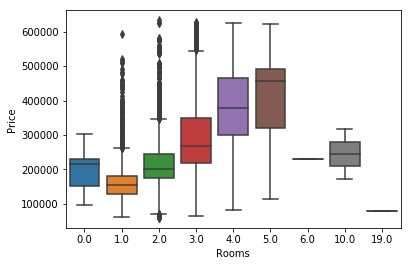

In [13]:
sns.boxplot(data['Rooms'], data['Price'])

Из графиков видно, что самые чистые данные находятся для 1 <= Rooms <= 5 в пределах 1 и 3 квартилей. Остальные, скорее всего, были заполнены с ошибками.

In [14]:
rooms_quantiles = data.where((data['Rooms'] >= 1) & ((data['Rooms'] <= 5))) \
.groupby('Rooms')[['Price']] \
.quantile(q=[0.25, 0.75], interpolation='nearest')
rooms_quantiles

Price
Rooms                    
1.0   0.25  128711.103732
      0.75  182212.201038
2.0   0.25  174523.257872
      0.75  243479.876105
3.0   0.25  218500.747041
      0.75  349768.675634
4.0   0.25  298885.660186
      0.75  465934.434276
5.0   0.25  310305.074733
      0.75  496026.671162

Составим фильтр, который выделит подмножество с идеальным отношением 'Rooms' <-> 'Price'

In [119]:
ideal_rooms_filter = lambda df: (
    ((df['Rooms'] == 1) & (df['Price'] >= 128600) & (df['Price'] <= 182300)) |
    ((df['Rooms'] == 2) & (df['Price'] >= 174400) & (df['Price'] <= 243600)) |
    ((df['Rooms'] == 3) & (df['Price'] >= 218400) & (df['Price'] <= 349900)) |
    ((df['Rooms'] == 4) & (df['Price'] >= 298800) & (df['Price'] <= 466000)) |
    ((df['Rooms'] == 5) & (df['Price'] >= 360000) & (df['Price'] <= 496100))
)
ideal_rooms_data = data.loc[ideal_rooms_filter, :]
print('Число записей: ', ideal_rooms_data['Id'].count(), '/', data['Id'].count())
ideal_rooms_data['Rooms'].value_counts()

Число записей:  5012 / 10000


2.0    1946
1.0    1860
3.0    1123
4.0      76
5.0       7
Name: Rooms, dtype: int64

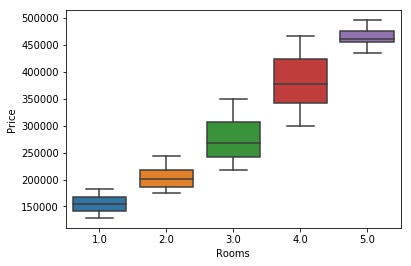

In [120]:
sns.boxplot(ideal_rooms_data['Rooms'], ideal_rooms_data['Price'])

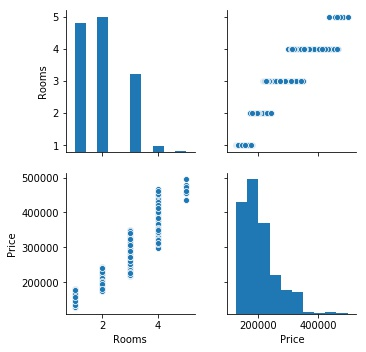

In [121]:
sns.pairplot(ideal_rooms_data.loc[:, ['Rooms', 'Price']])

### Фильтр 'Square'

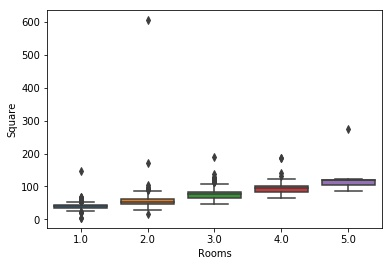

In [122]:
sns.boxplot(ideal_rooms_data['Rooms'], ideal_rooms_data['Square'])

In [123]:
square_quantiles = ideal_rooms_data.groupby('Rooms')[['Square']].quantile(q=[0.25, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   35.784271
      0.75   43.192992
2.0   0.25   46.273040
      0.75   63.056315
3.0   0.25   63.898844
      0.75   82.544433
4.0   0.25   82.945530
      0.75  101.978514
5.0   0.25  112.135525
      0.75  119.008007

Число записей:  3833 / 10000


1.0    1531
2.0    1353
3.0     893
4.0      52
5.0       4
Name: Rooms, dtype: int64

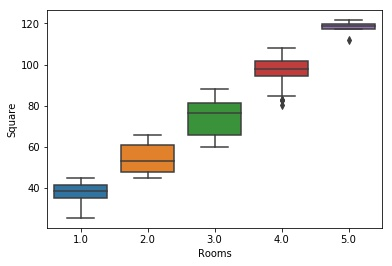

In [146]:
ideal_square_filter = lambda df: (
    ((df['Rooms'] == 1) & (df['Square'] >= 25) & (df['Square'] <= 45)) |
    ((df['Rooms'] == 2) & (df['Square'] >= 45) & (df['Square'] <= 66)) |
    ((df['Rooms'] == 3) & (df['Square'] >= 60) & (df['Square'] <= 88)) |
    ((df['Rooms'] == 4) & (df['Square'] >= 80) & (df['Square'] <= 110))|
    ((df['Rooms'] == 5) & (df['Square'] >= 100) & (df['Square'] <= 160))
)
ideal_square_data = data.loc[ideal_square_filter(data) & ideal_rooms_filter(data), :]
sns.boxplot(ideal_square_data['Rooms'], ideal_square_data['Square'])
print('Число записей: ', ideal_square_data['Id'].count(), '/', data['Id'].count())
ideal_square_data['Rooms'].value_counts()

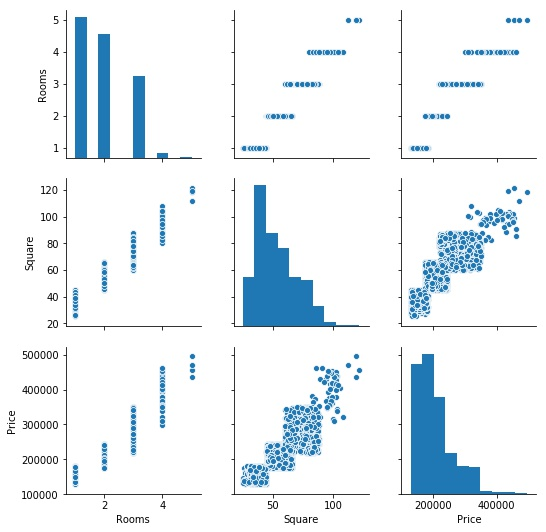

In [147]:
sns.pairplot(ideal_square_data.loc[:, ['Rooms', 'Square', 'Price']])

### Фильтр 'LifeSquare'

In [148]:
ideal_lifesquare_filter = lambda df: (
    (df['LifeSquare'].notna()) & 
    (df['LifeSquare'] < 200) & 
    (df['Square'] < 400) & 
    (df['LifeSquare'] > 10) &
    (df['LifeSquare'] < df['Square'] * 0.9) & 
    (df['LifeSquare'] > df['Square'] * 0.3)
)
ideal_lifesquare_data = data.loc[ideal_square_filter(data) & ideal_rooms_filter(data) & ideal_lifesquare_filter(data), :]
print('Число записей: ', ideal_lifesquare_data['Id'].count(), '/', data['Id'].count())
ideal_lifesquare_data['Rooms'].value_counts()

Число записей:  2892 / 10000


1.0    1180
2.0     989
3.0     682
4.0      38
5.0       3
Name: Rooms, dtype: int64

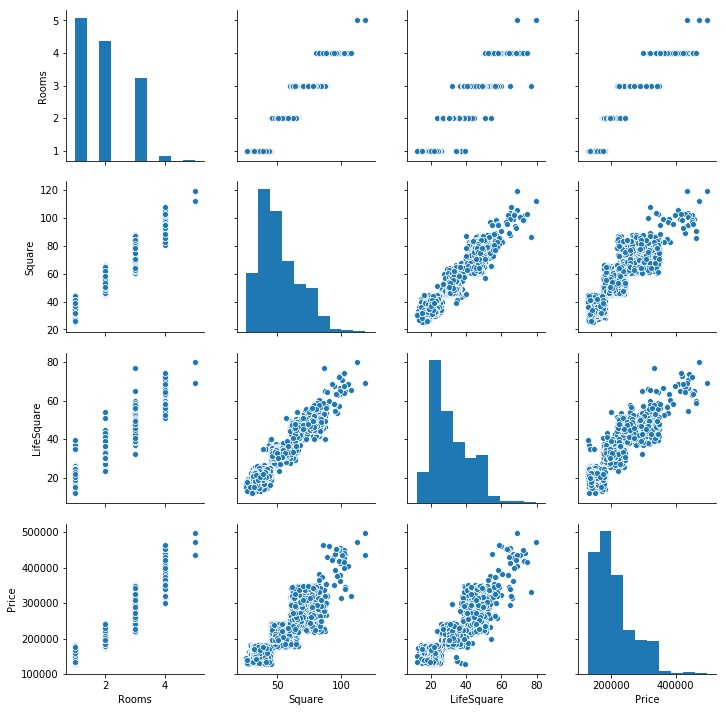

In [157]:
sns.pairplot(ideal_lifesquare_data.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']])

### Итоговый RSL-фильтр

In [152]:
ideal_rsl_filter = lambda df: ideal_square_filter(df) & ideal_rooms_filter(df) & ideal_lifesquare_filter(df)

In [155]:
print('Корреляция до фильтрации:')
data.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']].corr()

Корреляция до фильтрации:


,Rooms,Square,LifeSquare,Price
Rooms,1.000000,0.193684,0.521674,0.550291
Square,0.193684,1.000000,0.219987,0.142499
LifeSquare,0.521674,0.219987,1.000000,0.363570
Price,0.550291,0.142499,0.363570,1.000000


In [156]:
print('Корреляция после фильтрации:')
data.loc[lambda df: ideal_rsl_filter(df), ['Rooms', 'Square', 'LifeSquare', 'Price']].corr()

Корреляция после фильтрации:


,Rooms,Square,LifeSquare,Price
Rooms,1.000000,0.926810,0.954742,0.900373
Square,0.926810,1.000000,0.944970,0.895573
LifeSquare,0.954742,0.944970,1.000000,0.892682
Price,0.900373,0.895573,0.892682,1.000000


## Модели

Обучим на идеальном подмножестве выборки данных модели, которые исправят выбросы в данных

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


def model_fit(df_features, df_target):
    clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=[{'n_estimators': [100, 250, 500], 'max_depth': [5, 9, 15, 27]}],
                       cv=5)
    clf.fit(df_features, df_target)
    return clf


def show_model(clf_model):
    print('Лучшие параметры модели:', clf_model.best_params_)
    for mean, std, params in zip(clf_model.cv_results_['mean_test_score'], clf_model.cv_results_['std_test_score'], clf_model.cv_results_['params']):
        print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

### Модель для фиксов 'Rooms'

In [160]:
clf_rooms = model_fit(
    data.loc[lambda df: ideal_rsl_filter(df), ['Square', 'LifeSquare', 'Price']], 
    data.loc[lambda df: ideal_rsl_filter(df), 'Rooms']
)
show_model(clf_rooms)

Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 500}
0.9932 (±0.0033) for {'max_depth': 5, 'n_estimators': 100}
0.9933 (±0.0037) for {'max_depth': 5, 'n_estimators': 250}
0.9933 (±0.0037) for {'max_depth': 5, 'n_estimators': 500}
0.9936 (±0.0025) for {'max_depth': 9, 'n_estimators': 100}
0.9936 (±0.0027) for {'max_depth': 9, 'n_estimators': 250}
0.9937 (±0.0029) for {'max_depth': 9, 'n_estimators': 500}
0.9934 (±0.0022) for {'max_depth': 15, 'n_estimators': 100}
0.9934 (±0.0024) for {'max_depth': 15, 'n_estimators': 250}
0.9934 (±0.0026) for {'max_depth': 15, 'n_estimators': 500}
0.9934 (±0.0022) for {'max_depth': 27, 'n_estimators': 100}
0.9934 (±0.0024) for {'max_depth': 27, 'n_estimators': 250}
0.9934 (±0.0026) for {'max_depth': 27, 'n_estimators': 500}


### Модель для фиксов 'Square'

In [161]:
clf_square = model_fit(
    data.loc[lambda df: ideal_rsl_filter(df), ['Rooms', 'LifeSquare', 'Price']], 
    data.loc[lambda df: ideal_rsl_filter(df), 'Square']
)
show_model(clf_square)

Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 100}
0.9121 (±0.0110) for {'max_depth': 5, 'n_estimators': 100}
0.9120 (±0.0108) for {'max_depth': 5, 'n_estimators': 250}
0.9120 (±0.0109) for {'max_depth': 5, 'n_estimators': 500}
0.9077 (±0.0132) for {'max_depth': 9, 'n_estimators': 100}
0.9079 (±0.0136) for {'max_depth': 9, 'n_estimators': 250}
0.9078 (±0.0139) for {'max_depth': 9, 'n_estimators': 500}
0.9009 (±0.0147) for {'max_depth': 15, 'n_estimators': 100}
0.9015 (±0.0143) for {'max_depth': 15, 'n_estimators': 250}
0.9014 (±0.0147) for {'max_depth': 15, 'n_estimators': 500}
0.8988 (±0.0145) for {'max_depth': 27, 'n_estimators': 100}
0.8994 (±0.0142) for {'max_depth': 27, 'n_estimators': 250}
0.8993 (±0.0146) for {'max_depth': 27, 'n_estimators': 500}


### Модель для фиксов 'LifeSquare'

In [162]:
clf_lifesquare = model_fit(
    data.loc[lambda df: ideal_rsl_filter(df), ['Rooms', 'Square', 'Price']], 
    data.loc[lambda df: ideal_rsl_filter(df), 'LifeSquare']
)
show_model(clf_lifesquare)

Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 100}
0.9388 (±0.0110) for {'max_depth': 5, 'n_estimators': 100}
0.9387 (±0.0109) for {'max_depth': 5, 'n_estimators': 250}
0.9387 (±0.0110) for {'max_depth': 5, 'n_estimators': 500}
0.9359 (±0.0127) for {'max_depth': 9, 'n_estimators': 100}
0.9361 (±0.0129) for {'max_depth': 9, 'n_estimators': 250}
0.9359 (±0.0128) for {'max_depth': 9, 'n_estimators': 500}
0.9311 (±0.0138) for {'max_depth': 15, 'n_estimators': 100}
0.9315 (±0.0139) for {'max_depth': 15, 'n_estimators': 250}
0.9314 (±0.0139) for {'max_depth': 15, 'n_estimators': 500}
0.9290 (±0.0141) for {'max_depth': 27, 'n_estimators': 100}
0.9295 (±0.0140) for {'max_depth': 27, 'n_estimators': 250}
0.9294 (±0.0140) for {'max_depth': 27, 'n_estimators': 500}


## Устранение выбросов

In [215]:
data1 = data.copy()
data1.loc[data['LifeSquare'].isnull(), 'LifeSquare'] = data.loc[data['LifeSquare'].isnull(), 'Square'] * 0.85

In [216]:
def fix_lifesquare(adata, rsl_filter, model_lifesquare):
    print('Корелляция LifeSquare⇔Price до фиксов', adata.corr()['LifeSquare']['Price'])
    adata.loc[lambda df: ~rsl_filter(df), 'LifeSquare'] = model_lifesquare.predict(adata.loc[lambda df: ~rsl_filter(df), ['Rooms', 'Square', 'Price']])
    print('Корелляция LifeSquare⇔Price после фиксов', adata.corr()['LifeSquare']['Price'])
    return adata
data1 = fix_lifesquare(data.copy(), ideal_rsl_filter, clf_lifesquare)

Корелляция LifeSquare⇔Price до фиксов 0.36356966846690975
Корелляция LifeSquare⇔Price после фиксов 0.6259099227819707


In [217]:
def fix_square(adata, rsl_filter, model_square):
    print('Корелляция Square⇔Price до фиксов', adata.corr()['Square']['Price'])
    adata.loc[lambda df: ~rsl_filter(df), 'Square'] = model_square.predict(adata.loc[lambda d: ~rsl_filter(d), ['Rooms', 'LifeSquare', 'Price']])
    print('Корелляция Square⇔Price после фиксов', adata.corr()['Square']['Price'])
    return adata
data1 = fix_square(data1.copy(), ideal_rsl_filter, clf_square)

Корелляция Square⇔Price до фиксов 0.14249926312014716
Корелляция Square⇔Price после фиксов 0.6505623743259118


In [218]:
def fix_rooms(adata, rsl_filter, model_rooms):
    print('Корелляция Rooms⇔Price до фиксов', adata.corr()['Rooms']['Price'])
    adata.loc[lambda df: ~rsl_filter(df), 'Rooms'] = model_rooms.predict(adata.loc[lambda df: ~rsl_filter(df), ['Square', 'LifeSquare', 'Price']])
    print('Корелляция Rooms⇔Price после фиксов', adata.corr()['Rooms']['Price'])
    return adata
data1 = fix_rooms(data1.copy(), ideal_rsl_filter, clf_rooms)

Корелляция Rooms⇔Price до фиксов 0.5502907269258719
Корелляция Rooms⇔Price после фиксов 0.7981381144770673


In [181]:
data.loc[lambda df: ideal_rsl_filter(df), ['Rooms', 'Square', 'LifeSquare', 'Price']].corr()

,Rooms,Square,LifeSquare,Price
Rooms,1.000000,0.926810,0.954742,0.900373
Square,0.926810,1.000000,0.944970,0.895573
LifeSquare,0.954742,0.944970,1.000000,0.892682
Price,0.900373,0.895573,0.892682,1.000000


In [219]:
data1.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']].corr()

,Rooms,Square,LifeSquare,Price
Rooms,1.000000,0.872421,0.848479,0.798138
Square,0.872421,1.000000,0.961119,0.650562
LifeSquare,0.848479,0.961119,1.000000,0.625910
Price,0.798138,0.650562,0.625910,1.000000


## 'Floor', 'HouseFloor', 'HouseYear'

In [28]:
data.loc[:, ['Floor', 'HouseFloor', 'HouseYear']].describe()

,Floor,HouseFloor,HouseYear
count,10000.000000,10000.000000,1.000000e+04
mean,7.943200,13.192900,3.990166e+03
std,5.228127,6.372139,2.005003e+05
min,1.000000,0.000000,1.910000e+03
25%,4.000000,9.000000,1.974000e+03
50%,7.000000,14.000000,1.977000e+03
75%,11.000000,17.000000,2.001000e+03
max,42.000000,117.000000,2.005201e+07


In [30]:
invalid_hy_filter = lambda df: ((df['HouseYear'] < 1900) | (df['HouseYear'] > 2030))
data.loc[invalid_hy_filter, 'HouseYear'] = data['HouseYear'].median()
data.loc[:, ['HouseYear']].describe()

,HouseYear
count,10000.000000
mean,1984.863800
std,18.409979
min,1910.000000
25%,1974.000000
50%,1977.000000
75%,2001.000000
max,2020.000000


In [31]:
hf_basedon_year = data.groupby('HouseYear')['HouseFloor'].median()
hf_basedon_year.values

array([ 9. ,  8. ,  8. ,  6. ,  6. ,  5. ,  5. ,  5. ,  7. ,  6. ,  5. ,
        5. ,  6. ,  5. ,  7. ,  6. ,  5. ,  8. ,  6.5,  7. ,  7.5,  5. ,
        8. ,  9. ,  5. ,  6. ,  5. ,  5. ,  6. ,  6. ,  8. ,  6. ,  5. ,
        5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  6. ,  7. ,  9. ,  9. ,  9. ,
        9. ,  9. ,  9. ,  9. , 10. , 12. , 12. , 17. , 12. , 12. , 12. ,
       12. , 12. , 14. , 16. , 16. , 17. , 17. , 17. , 17. , 17. , 17. ,
       17. , 17. , 17. , 14.5, 14. , 14. , 14. , 17. , 17. , 17. , 17. ,
       17. , 17. , 17. , 17. , 17. , 17. , 17. , 17. , 17. , 19. , 17. ,
       17. , 17. , 17. , 17. , 17. , 17. , 22. ])

In [32]:
invalid_hf_filter = lambda df: ((df['HouseFloor'] == 0) | (df['HouseFloor'] > 50))
fixed_hf = data.loc[invalid_hf_filter, 'HouseYear'].map(hf_basedon_year.get)
data.loc[invalid_hf_filter, 'HouseFloor'] = fixed_hf
data.loc[:, ['Floor', 'HouseFloor', 'HouseYear']].describe()

,Floor,HouseFloor,HouseYear
count,10000.000000,10000.000000,10000.000000
mean,7.943200,13.623800,1984.863800
std,5.228127,5.794811,18.409979
min,1.000000,1.000000,1910.000000
25%,4.000000,9.000000,1974.000000
50%,7.000000,14.000000,1977.000000
75%,11.000000,17.000000,2001.000000
max,42.000000,48.000000,2020.000000


In [33]:
print('Корреляция до:')
perceptible_corr.loc[:, ['HouseFloor']].dropna(how='all')

Корреляция до:


,HouseFloor
DistrictId,-0.181800
LifeSquare,0.101077
Floor,0.528385
Healthcare_1,-0.173270
Price,0.106535


In [38]:
print('Корреляция после:')
data.corr().where(lambda df: (np.abs(df) > 0.1) & (np.abs(df) < 1)).loc[:, ['HouseFloor']].dropna(how='all')

Корреляция после:


,HouseFloor
DistrictId,-0.219881
LifeSquare,0.115982
Floor,0.598678
HouseYear,0.461408
Social_1,-0.106483
Healthcare_1,-0.191400
Helthcare_2,-0.140463
Price,0.107305


## Healthcare_1

In [39]:
healthcare_corr = data_final.loc[data_final['Healthcare_1'].notnull(), :].corr().loc[lambda df: (np.abs(df['Healthcare_1']) > 0.1) & (np.abs(df['Healthcare_1']) < 1), ['Healthcare_1']]
healthcare_corr

NameError: name 'data_final' is not defined

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
train_set = data_final.loc[data_final['Healthcare_1'].notnull(), :]
clf_healthcare = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                          param_grid=[{'n_estimators': [200, 250, 300], 'max_depth': [3, 5, 7, 9]}],
                          cv=5)
clf_healthcare.fit(
    train_set.loc[:, train_set.columns.isin(healthcare_corr.index.values)], 
    train_set.loc[:, train_set.columns == 'Healthcare_1'].values.ravel(), 
)
clf_healthcare.best_params_

NameError: name 'data_final' is not defined

In [37]:
for mean, std, params in zip(clf_healthcare.cv_results_['mean_test_score'], clf_healthcare.cv_results_['std_test_score'], clf_healthcare.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

NameError: name 'clf_healthcare' is not defined

In [ ]:
data_final.loc[data_final['Healthcare_1'].isnull(), 'Healthcare_1'] = clf_healthcare.predict(data_final.loc[data_final['Healthcare_1'].isnull(), healthcare_corr.index.values])

# Собираем итоговый датафрейм

In [221]:
def preprocessData(df, 
                   filter_rsl,         model_rooms, model_square, model_lifesquare,
                   filter_house_floor, df_house_floor_by_year,
                   filter_house_year
                  ):
    # 'Ecology_2', 'Ecology_3', 'Shops_2'
    df = one_hot_encoder(df)
    # подготавливаем 'LifeSquare', 'Square'
    df = swap_lifesquare_with_square(df.copy())
    # подготавливаем 'Floor', 'HouseFloor'
    df = swap_floor_with_housefloor(df.copy())
    # исправляем LifeSquare
    df = fix_lifesquare(df.copy(), filter_rsl, model_lifesquare)
    # исправляем Square
    df = fix_square(df.copy(), filter_rsl, model_square)
    # исправляем Rooms
    df = fix_rooms(df.copy(), filter_rsl, model_rooms)
    # исправляем HouseYear
    df.loc[filter_house_year, 'HouseYear'] = df['HouseYear'].median()
    # исправляем HouseFloor
    df.loc[filter_house_floor, 'HouseFloor'] = df.loc[filter_house_floor, 'HouseYear'].map(df_house_floor_by_year.get)
    # исправляем Healthcare_1
    df['Healthcare_1'] = df['Healthcare_1'].fillna(-999)
    return df

data_final = preprocessData(pd.read_csv('train.csv'),
                            ideal_rsl_filter, clf_rooms, clf_square, clf_lifesquare,
                            invalid_hf_filter, hf_basedon_year,
                            invalid_hy_filter
                           )

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0
Корелляция LifeSquare⇔Price до фиксов 0.36356966846690975
Корелляция LifeSquare⇔Price после фиксов 0.6259099227819707
Корелляция Square⇔Price до фиксов 0.14249926312014716
Корелляция Square⇔Price после фиксов 0.6505623743259118
Корелляция Rooms⇔Price до фиксов 0.5502907269258719
Корелляция Rooms⇔Price после фиксов 0.7981381144770673


# Масштабируем признаки

In [222]:
from sklearn.preprocessing import StandardScaler
train_columns = data_final.columns.copy().drop(['Id', 'Price'])
df_train = data_final.loc[:, train_columns]
df_test = data_final.loc[:, data_final.columns == 'Price']

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=train_columns)
df_train_scaled.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-0.353348,0.020567,-0.360280,-0.342945,-0.009569,-0.180418,-0.797961,-0.861739,-0.250529,0.474169,0.654880,-0.127533,-0.857652,-0.883480,1.408356,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
1,-0.215687,1.094075,0.774047,0.582501,0.060460,-0.180418,-0.797961,-0.372849,-0.998053,1.215681,1.237169,-0.295384,0.096048,-0.213923,2.448700,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
2,0.059635,0.020567,-0.374596,-0.451857,-0.219657,0.010865,-0.280230,-0.916060,-0.581588,0.531208,0.600720,-0.337347,0.087581,-0.213923,-0.256195,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864


# Предсказание
Наблюдаем за изменением главной метрики

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(
    df_train_scaled, 
    df_test, 
    test_size=0.25, 
    random_state=42
)

## LinearRegression

In [224]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Начальное значение:', 0.45173783173008786)
r2_score(y_test, y_pred)

Начальное значение: 0.45173783173008786


0.6889036066775029

## DecisionTreeRegressor

In [225]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=9)
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
print('Начальное значение:', 0.6353812140583176)
r2_score(y_test, y_pred)

Начальное значение: 0.6353812140583176


0.8872402734137114

## RandomForestRegressor с обучением на фолдах

In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=[{'n_estimators': [500], 
                 'max_depth': [27],
                 'max_features': [15]}],
    cv=5
)
clf_final.fit(df_train_scaled, df_test.values.ravel())
clf_final.best_params_

{'max_depth': 27, 'max_features': 15, 'n_estimators': 500}

In [227]:
for mean, std, params in zip(clf_final.cv_results_['mean_test_score'], clf_final.cv_results_['std_test_score'], clf_final.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.9378 (±0.0146) for {'max_depth': 27, 'max_features': 15, 'n_estimators': 500}


In [229]:
y_pred = clf_final.predict(x_test)
r2_score(y_test, y_pred)

0.9909484021161874